# Cough Audio Signal Classification

Cough audio signal classification has been successfully used to diagnose a variety of respiratory conditions, and there has been significant interest in leveraging Machine Learning (ML) to provide widespread COVID-19 screening.

This dataset, also known as CoughVid, provides over 25,000 crowdsourced cough recordings representing a wide range of participant ages, genders, geographic locations, and COVID-19 statuses.

My goal is to build a classifier that is able to correctly label Covid and healthy samples.

Source: https://www.kaggle.com/datasets/andrewmvd/covid19-cough-audio-classification

Dataset publication: https://www.nature.com/articles/s41597-021-00937-4

##0. Download and Import

I stored most of the files on Google Drive as some of them, even compressed, weight too much for github.


Since some parts of the project require high computation time, i stored some "checkpoint" file to speed up the overall execution of the notebook.


**ADVICE**

**The audio data segmentation takes a couple of hours to complete, for this reason, if you want to test the models, i advice you to install and import the libraries, and then execute the notebook from the section 4.2.  There you will find a checkpoint that allows you to download the final dataset.**

In [ ]:
#Downloading the dataset, previously uploaded on drive

! gdown 1Wh658r1a4ca0j700lU07R-JYwGb1AVp1
! mkdir data
! unzip 'archive (3).zip' -d data

In [ ]:
#Since the audio files have different lenghts, and can contain multiple coughs
#I upload some scripts from this github repository for audio segmentation

! git clone https://github.com/bagustris/detect-segment-cough

Cloning into 'detect-segment-cough'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 116 (delta 49), reused 95 (delta 35), pack-reused 0
Receiving objects: 100% (116/116), 821.72 KiB | 17.48 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
! mv detect-segment-cough/* .
! rm *py
! mv src/* .
! rm DSP.py

#i modified some of the scripts from the repository to fix some bugs
! gdown 1bGHweI1eGHTCDiJ70Lsp5Y9-2Ze3ZjyH
! gdown 1D9uxwWpYOwYKnfZeerfy5i_R8hzeOte1
! gdown 1-AWid-TEtwofp92trVNKz0wNhyn6esok

Downloading...
From: https://drive.google.com/uc?id=1bGHweI1eGHTCDiJ70Lsp5Y9-2Ze3ZjyH
To: /content/detect_cough.py
100% 1.20k/1.20k [00:00<00:00, 4.57MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D9uxwWpYOwYKnfZeerfy5i_R8hzeOte1
To: /content/segment_cough.py
100% 1.28k/1.28k [00:00<00:00, 4.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-AWid-TEtwofp92trVNKz0wNhyn6esok
To: /content/DSP.py
100% 2.98k/2.98k [00:00<00:00, 14.9MB/s]


In [ ]:
!pip install tensorflow==2.9.0 tensorflow-io==0.26.0 pydub xgboost==0.90 scipy audiomentations pyroomacoustics

In [64]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn
import pandas as pd
import joblib
pd.set_option('display.max_columns', None)
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import os
from pydub import AudioSegment
import xgboost
import scipy
#import detect_cough, segment_cough
import subprocess
import re
from tqdm import tqdm
import random
import pickle
import soundfile as sf
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import sklearn
from audiomentations import Compose, AddGaussianNoise, PitchShift
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, log_loss
from keras.layers import Conv2D, Flatten, Dense, BatchNormalization
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
from sklearn.model_selection import GridSearchCV

## 1. Metadata analysis

The dataset comes with a metadata table providing information for each one of the audio file, indicated with an "uuid".

In [ ]:
df = pd.read_csv("data/metadata_compiled.csv")
df.head()

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 Metadata filtering

In [ ]:
df.shape

(27550, 51)

In [ ]:
df.isnull().sum()

uuid                         0
datetime                     0
cough_detected               0
SNR                          0
latitude                 11466
longitude                11466
age                      12332
gender                   11326
respiratory_condition    11326
fever_muscle_pain        11326
status                   11326
quality_1                26730
cough_type_1             26748
dyspnea_1                26730
wheezing_1               26730
stridor_1                26730
choking_1                26730
congestion_1             26730
nothing_1                26730
diagnosis_1              26748
severity_1               26748
quality_2                26730
cough_type_2             26749
dyspnea_2                26730
wheezing_2               26730
stridor_2                26730
choking_2                26730
congestion_2             26730
nothing_2                26730
diagnosis_2              26748
severity_2               26748
quality_3                26730
cough_ty

The dataset is also used for regression purpuoses, as i will use it for classification, and most of the features will be extracted from the audio signal, i will remove the columns with missing values.

In [ ]:
df.set_index('uuid', inplace=True)
df = df.drop(columns=(df.isnull().sum()[df.isnull().sum() > 20000].index))
df = df.drop(columns=["latitude","longitude","datetime","fever_muscle_pain","respiratory_condition","age","gender"])
df.shape

(27550, 3)

This leaves us with the "SNR" and "Cough detected" columns (which are needed for quality control) and the "status" column (storing the class).

In [ ]:
df.status.value_counts()

healthy        12479
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64

The classes are highly unbalanced.
For my analisys i will remove the symptomatic cases, because since there is no way to know if they have other respiratory conditions or covid, they might disrupt the efficiency of the model.


In [ ]:
df = df[df['status'] != "symptomatic"]

In [ ]:
df['status'] = df['status'].replace({'healthy':0,'COVID-19':1})

In [ ]:
#There are 11326 rows without the class, since its crucial for the project, i have to remove these rows
data = df.dropna(subset=['status'])
data.shape

(13634, 3)

In [ ]:
data.status.value_counts()

0.0    12479
1.0     1155
Name: status, dtype: int64

In [ ]:
data.describe()

,cough_detected,SNR,status
count,13634.000000,1.363400e+04,13634.000000
mean,0.749713,inf,0.084715
std,0.337003,NaN,0.278467
min,0.000000,-2.762143e+00,0.000000
25%,0.591975,8.011072e+00,0.000000
50%,0.943200,1.320809e+01,0.000000
75%,0.990300,2.161766e+01,0.000000
max,1.000000,inf,1.000000


Signal-to-noise ratio (SNR or S/N) is a measure that compares the level of a desired signal to the level of background noise. SNR is defined as the ratio of signal power to noise power, often expressed in decibels. A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise.

Since i have already a small amount of covid audio, i will filter out rows having negative or infinite SNR, and keep all the other values.

The Cough_detected column stores the probability of having a "cough" inside the audo files. Reading the paper that published the dataset i see that they used 0.8 as threshold for the analysis. I used 0.5 as i will also detect the cough personally later in the segmentation phase. If some artifacts get past this phase, they will be removed in the second cut.



In [ ]:
#Quality filtering
data = data[data['cough_detected'] > 0.5]
data = data[data['SNR'] < 999]
data = data[data['SNR'] > 0]
data.shape

(9818, 3)

In [ ]:
data.status.value_counts()

0.0    9091
1.0     727
Name: status, dtype: int64

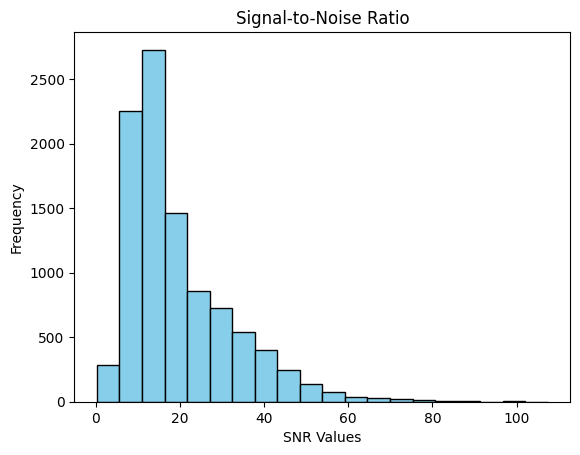

In [ ]:
plt.hist(data['SNR'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('SNR Values')
plt.ylabel('Frequency')
plt.title('Signal-to-Noise Ratio')
plt.show()

In [ ]:
#We wont be using this feature again as we will detect our own cough probability
data.drop(["cough_detected"],axis=1,inplace = True)

## 2. Audio Pre-processing

### 2.1 Format Conversion

Sample rate is the number of samples of audio carried per second, measured in Hz or kHz (one kHz being 1,000 Hz). For example, 44100 samples per second can be expressed as either 44,100 Hz, or 44.1 kHz.

In [ ]:
def load_wav_16k_mono(filename):
    # Convert webm file to wav using pydub
    audio = AudioSegment.from_file(filename, format="webm")
    filename = filename.replace('.webm', '.wav')
    #Convert into a 16-bit file
    audio = audio.set_sample_width(2)
    #export
    audio.export(filename, format="wav")

    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

#This function will be used to call each one of the audio files

### 2.2 Audio analysis

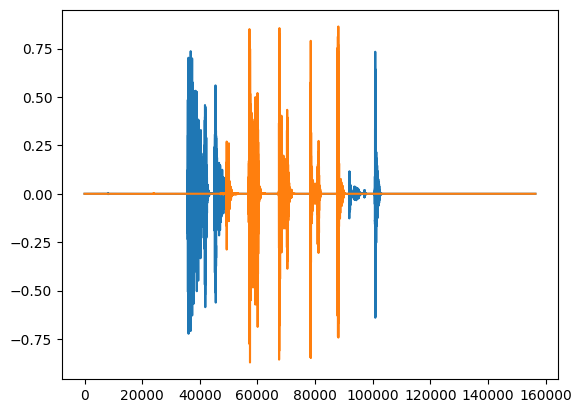

In [ ]:
#Visualizing an healthy and covid case
healthy = load_wav_16k_mono("data/%s.webm" % (data[data.status==0].iloc[0].name))
covid = load_wav_16k_mono("data/%s.webm" % (data[data.status==1].iloc[0].name))
plt.plot(healthy)
plt.plot(covid)
plt.show()

Checking the lenght distribution of the audio

In [ ]:
%time
lengths = []
for filename in tqdm(data[data.status==1].index):
    try:
        tensor_wave = load_wav_16k_mono("data/%s.webm" % filename)
        lengths.append(len(tensor_wave))
    except FileNotFoundError:
        data.drop(filename, inplace=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


100%|██████████| 727/727 [03:53<00:00,  3.11it/s]


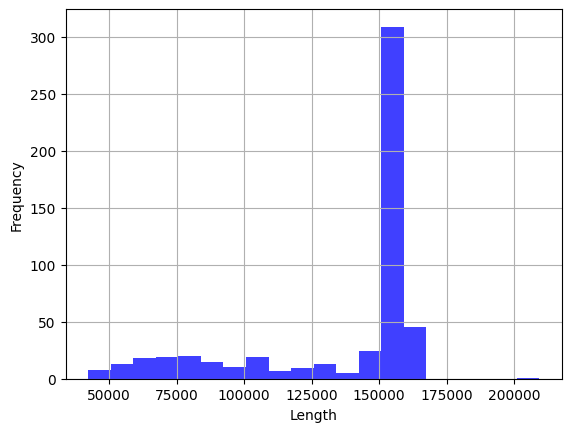

In [ ]:
def plot_length_histogram(lengths_list):
    plt.hist(lengths_list, bins=20, alpha=0.75, color='b')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_length_histogram(lengths)

In [ ]:
#To get the measure in seconds we need to divide by the Hz (16000 cycles per second)

print("MEAN",tf.math.reduce_mean(lengths)/16000)
print("MIN",tf.math.reduce_min(lengths)/16000)
print("MAX",tf.math.reduce_max(lengths)/16000)

MEAN tf.Tensor(8.534875, shape=(), dtype=float64)
MIN tf.Tensor(2.64, shape=(), dtype=float64)
MAX tf.Tensor(13.08, shape=(), dtype=float64)


Average Covid Audio lenght is of 8.5s

But the range is quite wide.

### 2.3 Segmentation

Since there are different amounts of coughs in the audio files, and the general lenght is varying quite a lot, it's necessary to go through audio segmentation.

The goal is to isolate each cough from each file and end up with the same lenght for each file.

#### Testing the segmentation

In [ ]:
# Load the audio file
load_wav_16k_mono("data/%s.webm" % (data[data.status==0].iloc[0].name))
filename = "data/%s.wav" % (data[data.status==0].iloc[0].name)

In [ ]:
#Computing the probability of having a cough in the file
command = f"python detect_cough.py -i {filename}"
cough_prob = float(subprocess.check_output(command, shell=True, text=True).split(" ")[-1].strip())
cough_prob

0.9608511328697205

In [ ]:
# Set a threshold for cough probability. Once again 0.5 to avoid losing too much data.
cough_threshold = 0.5
output = filename.split('.')[0]+"_processed"
# Segment coughs if the probability is above the threshold
if cough_prob > cough_threshold:
    ! mkdir {output}
    command = f"python segment_cough.py -i {filename} -o {output}/"
    subprocess.check_output(command, shell=True, text=True)
    # Saves segmented coughs as separate files in a folder


In [ ]:
! ls {output}

00039425-7f3a-42aa-ac13-834aaa2b6b92-0.wav
00039425-7f3a-42aa-ac13-834aaa2b6b92-1.wav


In [ ]:
#Full file
ipd.Audio(filename,rate=16000)

In [ ]:
#Split 1
ipd.Audio(f"{output}/{filename.split('.')[0].split('/')[-1]}-0.wav",rate=16000)

In [ ]:
#Split 2
ipd.Audio(f"{output}/{filename.split('.')[0].split('/')[-1]}-1.wav",rate=16000)


#### Segmenting Covid Samples

In [ ]:
def segmentation(filename,cough_th=0.5,audio_lenght=0.5,sr=16000):
    command = f"python detect_cough.py -i {filename}"
    cough_prob = float(subprocess.check_output(command, shell=True, text=True).split(" ")[-1].strip())
    output = filename.split('.')[0]+"_processed"
    lenghts = []
    # Segment coughs if the probability is above the threshold, count the number of coughs in the file
    count = 0
    if cough_prob > cough_th:
        ! mkdir {output}
        command = f"python segment_cough.py -i {filename} -o {output}/"
        subprocess.check_output(command, shell=True, text=True)
        for file in os.listdir(output):
            file_path = os.path.join(output, file)
            audio, _ = librosa.load(file_path, sr=sr)
            #After isolating the cough, we pad the file to have the same lenght in each one of them.
            padded_cough = librosa.util.fix_length(audio,size= int(audio_lenght * sr))
            sf.write(file_path, padded_cough, sr)
            count+=1
    return  count


In [ ]:
data

,SNR,status
uuid,,
00039425-7f3a-42aa-ac13-834aaa2b6b92,16.151433,0.0
0009eb28-d8be-4dc1-92bb-907e53bc5c7a,20.146058,0.0
001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,13.146502,0.0
001e2f19-d81c-4029-b33c-d2db56b23a4a,12.566406,0.0
0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,13.477551,0.0
...,...,...
ffe0658f-bade-4654-ad79-40a468aabb03,21.960583,1.0
ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,11.209351,0.0
ffedc843-bfc2-4ad6-a749-2bc86bdac84a,33.661082,0.0


In [ ]:
covid_data = data.loc[data.status==1]
covid_data.shape
#This is the amount of audio file that i was left after the filtering

(727, 2)

In [ ]:
def segm_pipeline(data):
    counts = []
    for audio in tqdm(data.index):
        filename = "data/%s.webm" % (audio)
        #We try to load the file and convert it to 16k, if the file is not found, the uuid in the metadata is referring to a missing entry and has to be dropped
        try:
            load_wav_16k_mono(filename)
        except FileNotFoundError:
            data.drop(audio,inplace=True)
            continue
        filename = "data/%s.wav" % (audio)
        #We segment, and for each audio, we append in the metadata dataframe the number of coughs detected
        count= segmentation(filename)
        if count == 0: data.drop(audio,inplace=True)
        else:counts.append(count)
    data["n_coughs"] = counts
    return data

In [ ]:
covid_data = segm_pipeline(covid_data)

In [ ]:
print(covid_data.n_coughs.sum())
#After splitting the audio files, we go from 727 to 1771

1771


In [ ]:
def duplicate_rows(row):
    #Adding one row for each cough detected
    new_rows = []
    for i in range(int(row['n_coughs'])):
        new_row = row.copy()
        new_row['uuid'] = f"{row.name}-{i}"
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)


In [ ]:
# Apply the function to each row and concatenate the results
covid_data = pd.concat(covid_data.apply(duplicate_rows, axis=1).tolist(), ignore_index=True)
covid_data.drop(columns=['n_coughs'], inplace=True)
covid_data.set_index('uuid', inplace=True)
covid_data.head()

,SNR,status
uuid,,
015576c8-2b03-4dcb-b251-78a984fe86fe-0,12.265701,1.0
015576c8-2b03-4dcb-b251-78a984fe86fe-1,12.265701,1.0
0177b817-0ba3-498a-bc05-48bc66cc91b8-0,20.441756,1.0
01820f7c-b953-4faf-aa13-978cfda6b08e-0,9.280698,1.0
01820f7c-b953-4faf-aa13-978cfda6b08e-1,9.280698,1.0


In [ ]:
covid_data.to_csv("augmented_covid_metadata.csv")

In [ ]:
#Checkpoint
#!gdown 1yAY33_KyC-c2hxGtgLBo6N1hZLd_Z-NG
#covid_data = pd.read_csv("augmented_covid_metadata.csv",index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1he8-yc8oMTyaQwLgLXqEdnf_PYgUDm7E
To: /content/augmented_covid_metadata.csv
100% 99.9k/99.9k [00:00<00:00, 14.0MB/s]


#### Segmenting Healthy samples

I have too many healthy recordings, to speed up the computation i take only 1771 (to mimic the segmented amount of covid data)

In [ ]:
data_healthy = data.loc[data.status==0]
data_healthy.shape

(9091, 2)

In [ ]:
random_seed = 12345
np.random.seed(random_seed)
data_healthy = data_healthy.sample(covid_data.shape[0])
data_healthy.shape

(1771, 2)

In [ ]:
data_healthy = segm_pipeline(data_healthy)
data_healthy.head()

  0%|          | 0/1771 [00:00<?, ?it/s]

mkdir: cannot create directory ‘data/1550382d-9c94-4804-a48b-d5fad49a6f74_processed’: File exists


100%|██████████| 1771/1771 [1:56:11<00:00,  3.94s/it]


,SNR,status,n_coughs
uuid,,,
1550382d-9c94-4804-a48b-d5fad49a6f74,22.694652,0.0,1
f8eb36ba-e1ab-4bb7-9058-db0b88479fbb,12.218004,0.0,5
2d3798dc-51ab-4e80-8fca-e5e64b8d267e,13.528050,0.0,6
dd26fd38-5dc3-44ad-8749-528ea1449afc,15.976266,0.0,5
d07e4f28-d901-4c74-a849-ccaa432173f8,5.402712,0.0,3


In [ ]:
# Apply the function to each row and concatenate the results
data_healthy = pd.concat(data_healthy.apply(duplicate_rows, axis=1).tolist(), ignore_index=True)
data_healthy.drop(columns=['n_coughs'], inplace=True)
data_healthy.set_index('uuid', inplace=True)
data_healthy.head()

,SNR,status
uuid,,
1550382d-9c94-4804-a48b-d5fad49a6f74-0,22.694652,0.0
f8eb36ba-e1ab-4bb7-9058-db0b88479fbb-0,12.218004,0.0
f8eb36ba-e1ab-4bb7-9058-db0b88479fbb-1,12.218004,0.0
f8eb36ba-e1ab-4bb7-9058-db0b88479fbb-2,12.218004,0.0
f8eb36ba-e1ab-4bb7-9058-db0b88479fbb-3,12.218004,0.0


In [ ]:
data_healthy.to_csv("healthy_metadata_augmented.csv")

In [ ]:
#Checkpoint
#!gdown 1HT6LYhXtqtJhocaWIwUVF7Ll5WJtB7cm
#data_healthy=pd.read_csv("healthy_metadata_augmented.csv",index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1HT6LYhXtqtJhocaWIwUVF7Ll5WJtB7cm
To: /content/healthy_metadata_augmented.csv
100% 234k/234k [00:00<00:00, 96.4MB/s]


In [ ]:
data_healthy.shape

(4260, 2)

In [ ]:
covid_data.shape

(1771, 2)

In [ ]:
#Combine healthy e covid
final_df = pd.concat([covid_data, data_healthy])

# Shuffle the rows
final_df = final_df.sample(frac=1, random_state=42)
final_df

,SNR,status
uuid,,
f27f0740-c649-41ad-b48e-8dfe01e8a7a4-1,38.747053,0.0
1c34e7b6-708b-412c-b934-4af1e2990f67-4,22.058873,0.0
c31b14d1-9cb1-4269-9de5-23408a4d0c42-0,14.251257,1.0
f7c58675-8e00-41ea-81ce-c9ea5c6f52cd-1,12.366064,0.0
a2db8e27-5c45-4a68-896e-0aba47c6e1cf-1,10.059927,0.0
...,...,...
5bb5fb82-ce54-4e1a-84d5-12ca1b8bdcd4-0,8.329606,0.0
44d79c14-0c71-4ccd-bba1-ec66264a2d8f-2,5.615795,0.0
83ed8cad-daf7-42ec-a016-1bdf1a98894c-0,26.870339,0.0


In [ ]:
final_df.shape

(6031, 2)

In [ ]:
final_df.to_csv("final_metadata.csv")
!mkdir final_data
!mv data/*processed final_data
!tar -zcvf processed_audio_coughs.tar.gz final_data

## 3. Data Augmentation
Since the dataset is heavily unbalanced towards negatives, i had to augment the positives.

### 3.1 Train-Test split

In [ ]:
#Checkpoint
#! gdown 1Imw5_rgBKWE5B_fao1HyQ73QJi-RTuON
#! tar -xvzf processed_audio_coughs.tar.gz
#! gdown 1VsacaNeaq5eUeoRK8vburDdT82XP4TAi

In [ ]:
final_df = pd.read_csv("final_metadata.csv",index_col=0)
final_df.status.value_counts()

0.0    4260
1.0    1771
Name: status, dtype: int64

I split the dataset as i will perform data augmentation only on the training/validation set.

In [ ]:
# Split the data into train and test sets
train_df, test_df = train_test_split(final_df, test_size=0.3, random_state=12345,stratify=final_df.status)

# Add a 'set' column to indicate whether a row belongs to 'train' or 'test'
train_df['set'] = 'train'
test_df['set'] = 'test'



In [ ]:
train_df.status.value_counts()

0.0    2982
1.0    1239
Name: status, dtype: int64

### 3.2 Train data augmentation

In [ ]:
train_df.head()

,SNR,status,set
uuid,,,
03bc7116-7785-40fc-9217-b273b1803bad-1,13.502934,0.0,train
2295a6f8-08d5-467f-8534-8329c9083f28-1,9.680350,0.0,train
7cf08d23-ed1e-41fa-86d4-3ec4e6b67660-2,8.600554,0.0,train
4b910657-348b-4a87-bf93-257fd2081cfa-1,34.490788,1.0,train
585ecc76-a3f5-481e-97a1-ec6d69ec8b85-3,11.554328,0.0,train


I tested many modifications on my audio files. In the end i decided to stick with pitch shift and addition of gaussian noise, as these two can produce files that differ from the original samples but that are still recognisable as coughs. Pitch is a perceptual property of sounds that allows their ordering on a frequency-related scale,or more commonly, pitch is the quality that makes it possible to judge sounds as "higher" and "lower" in the sense associated with musical melodies. Pitch is a major auditory attribute of musical tones, along with duration, loudness, and timbre

Source: https://github.com/iver56/audiomentations

The library applies both modifications (since i set p=1, which is the probability) to each audio file, but the shift/noise is randomized and included in the specified range.

In [ ]:
augment_raw_audio = Compose(
    [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
        PitchShift(min_semitones=-8, max_semitones=8, p=1),
    ]
)

####Augmentation test

In [ ]:
signal, sr = librosa.load(f"final_data/{train_df.index[1][:-2]}_processed/{train_df.index[1]}.wav")
augmented_signal = augment_raw_audio(signal, sr)
sf.write("augmented_audio.wav", augmented_signal, sr)

#Modified
ipd.Audio("augmented_audio.wav",rate=16000)

#In this case, the pitch seems to be increased

In [ ]:
#Original
ipd.Audio(f"final_data/{train_df.index[0][:-2]}_processed/{train_df.index[1]}.wav",rate=16000)

#### Producing augmented files

In [ ]:
def data_aug(data,n_aug=1):
    '''
    This function takes in input the dataframe and the number of augmentations to perform per audio-file.
    New audio will have the same uuid plus an additional letter
    '''
    letters="ABCDEFG"
    for uuid in tqdm(data.index):
        #take uuid
        if uuid[-2] == "-": cut_uuid=uuid[:-2]
        else:cut_uuid=uuid[:-3]

        for n in range(0,n_aug):
            #load file
            signal, sr = librosa.load(f"final_data/{cut_uuid}_processed/{uuid}.wav")
            #Perform the augmentation and store the new audio
            augmented_signal = augment_raw_audio(signal, sr)
            sf.write(f"final_data/{cut_uuid}_processed/{uuid}{letters[n]}.wav", augmented_signal, sr)
            #Add the file uuid to the dataframe
            row = data.loc[uuid]
            data.loc[uuid+letters[n]]=row
    return data

In [ ]:
import warnings
warnings.filterwarnings("ignore")
pos_train = data_aug(train_df.loc[train_df.status==1],n_aug=2)
#I augmented positive exemples x2, to reach some sort of balance in the dataset
#I tried also with 1 and 3 augmentations per file, but the performace of the model was worse

100%|██████████| 1239/1239 [01:10<00:00, 17.62it/s]


In [ ]:
#I concatenate positives and negatives
train_df = pd.concat([train_df.loc[train_df.status==0], pos_train], ignore_index=False)
train_df.status.value_counts()

1.0    3717
0.0    2982
Name: status, dtype: int64

In [ ]:
#And then i add the test set back
final_df = pd.concat([train_df, test_df], ignore_index=False)
final_df.shape

(8509, 3)

In [ ]:
#I remove the SNR columns as i wont need it
final_df.drop(["SNR"],axis=1,inplace=True)
final_df

,status,set
uuid,,
03bc7116-7785-40fc-9217-b273b1803bad-1,0.0,train
2295a6f8-08d5-467f-8534-8329c9083f28-1,0.0,train
7cf08d23-ed1e-41fa-86d4-3ec4e6b67660-2,0.0,train
585ecc76-a3f5-481e-97a1-ec6d69ec8b85-3,0.0,train
ea2ab2b3-c6ff-40f7-932d-11a4f6508672-1,0.0,train
...,...,...
1637a580-6f5d-4ce9-9fdf-5019f8e6a2c9-1,0.0,test
99b2dc16-7b5f-4d45-99b2-c3768262be3a-1,1.0,test
d0a4cbf7-263d-49f1-978d-8cf767546e3c-2,1.0,test


In [ ]:
!tar -zcvf processed_audio_coughs_augmented.tar.gz final_data

In [ ]:
final_df.to_csv("final_metadata_augmented.csv")

## 4. Audio signal feature extraction

### 4.1 Example and explanation

In [ ]:
uuid = final_df.loc[final_df.status==0].iloc[0].name
uuid[:-2]

'f27f0740-c649-41ad-b48e-8dfe01e8a7a4'

In [ ]:
ipd.Audio(f"final_data/{uuid[:-2]}_processed/{uuid}.wav",rate=44100)

In [ ]:
signal, sr = librosa.load(f"final_data/{uuid[:-2]}_processed/{uuid}.wav")

I selected MFCCS, their deltas and their delta-deltas as features for my model training.

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

***Mel-frequency cepstral coefficients*** (MFCCs) are coefficients that collectively make up an MFC.They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression that might potentially reduce the transmission bandwidth and the storage requirements of audio signals.

MFCCs are commonly derived as follows:

- Take the Fourier transform of (a windowed excerpt of) a signal.
- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.
- Take the logs of the powers at each of the mel frequencies.
- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
- The MFCCs are the amplitudes of the resulting spectrum.

Since, Mel-frequency bands are distributed evenly in MFCC and they are much similar to the voice system of a human, thus, MFCC can efficiently be used to characterize speakers. They describes the instantaneous, spectral envelope shape of the speech signal. However, speech signals are time-variant signals and in a constant flux. Though we describe speech in linguistics as concatenated sequences of phonemes, the acoustical signal is more accurately described as a sequence of transitions between phonemes.

A common method for extracting information about such transitions is to determine the first difference of signal features, known as the delta of a feature, and the second difference, known as the delta-delta.

For more information:
- https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html
- https://speechprocessingbook.aalto.fi/Representations/Deltas_and_Delta-deltas.html

In [ ]:
#Extracting the mfccs from my signal
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

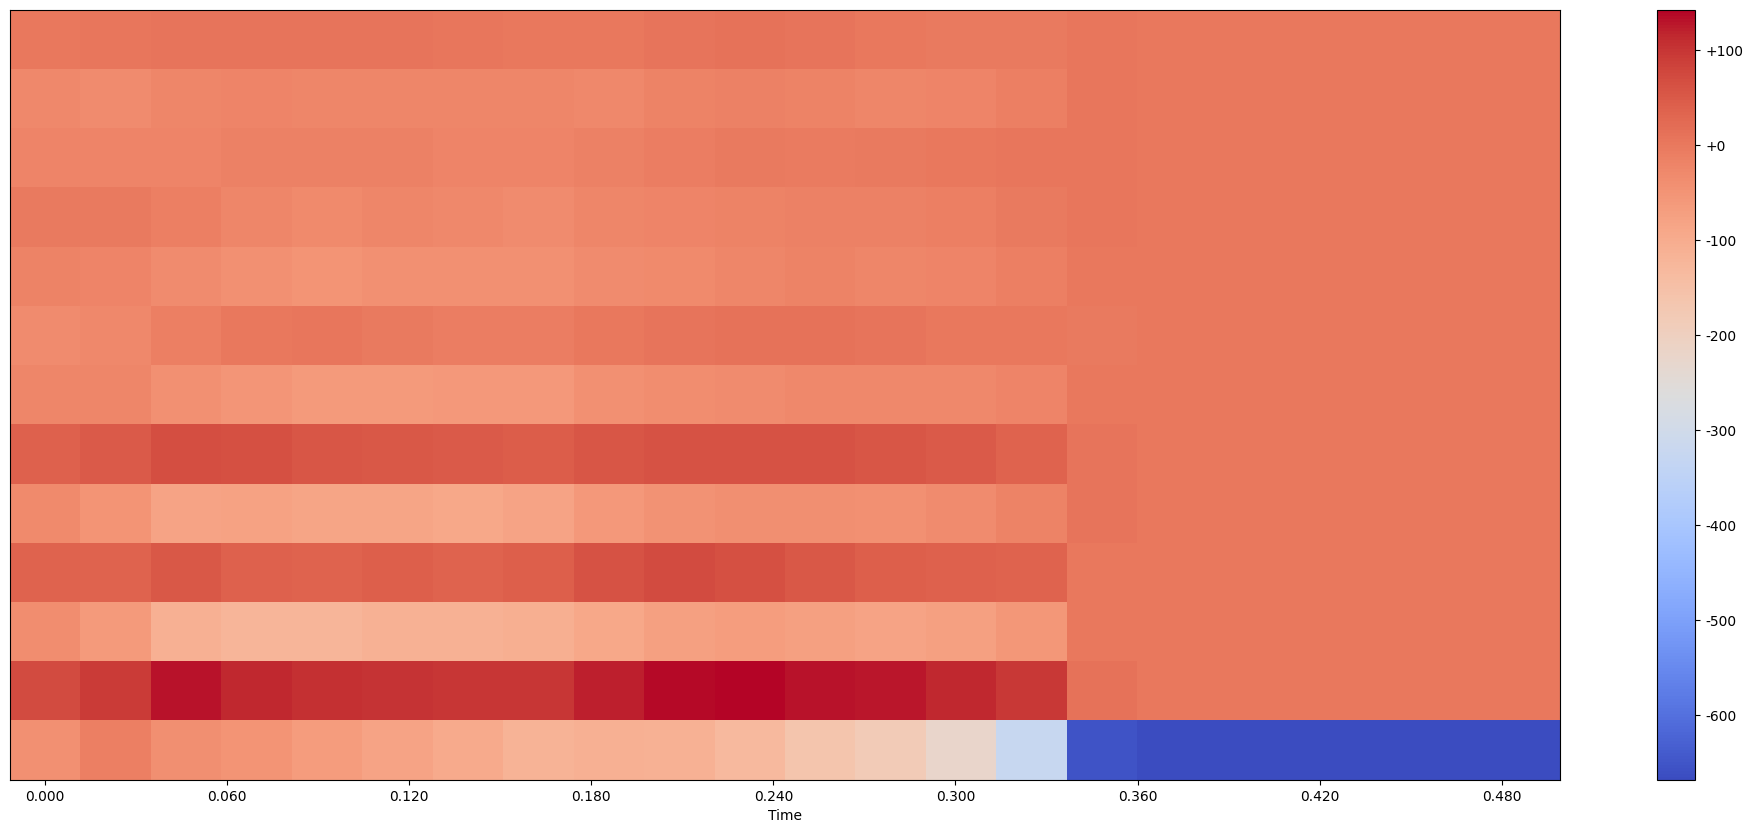

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

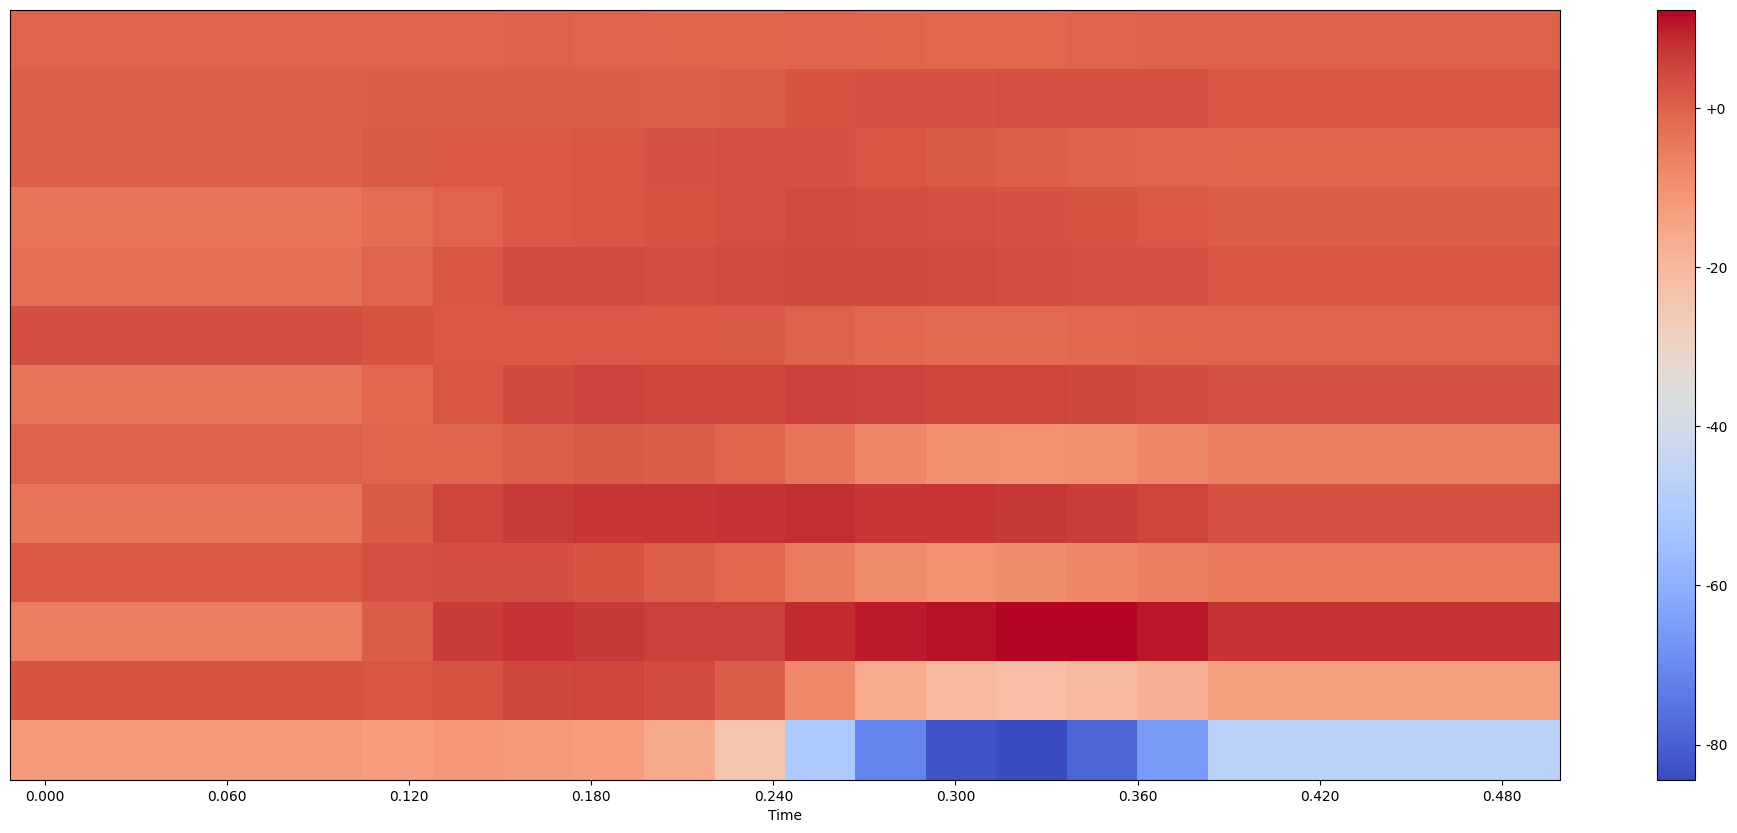

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta_mfccs,
                         x_axis="time",
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

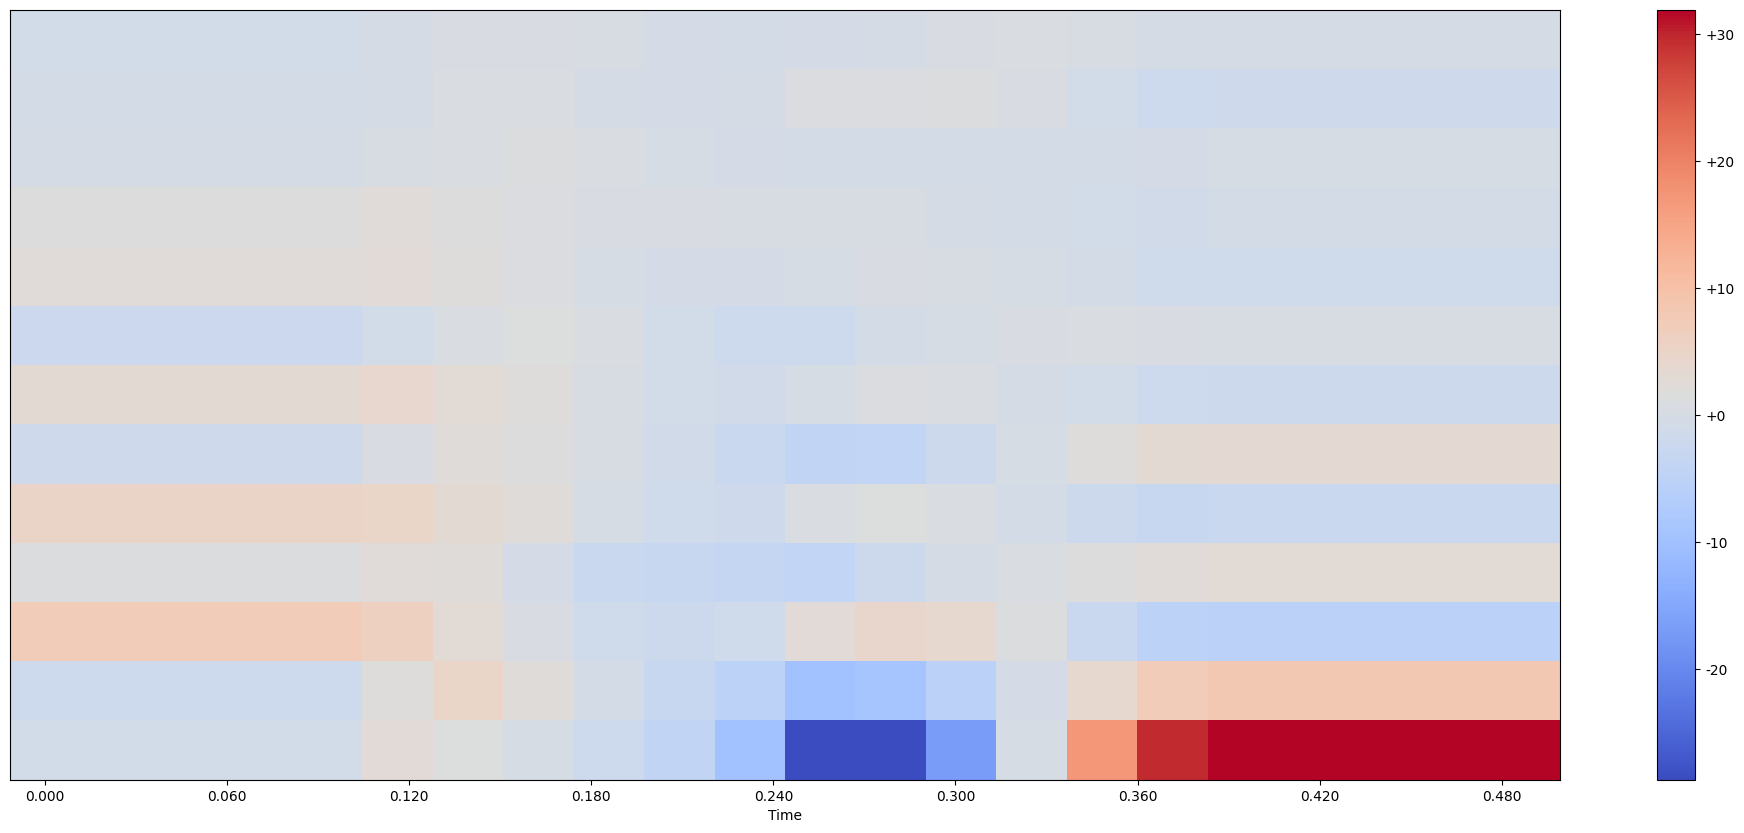

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2_mfccs,
                         x_axis="time",
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
mfccs_features.shape

(39, 22)

### 4.2 Tensor preparation


In [ ]:
#Checkpoint
#! gdown 12hQO8lGe7iHPyb15YT3M7MHY-jmlrsS6
#! tar -xvzf processed_audio_coughs_augmented.tar.gz

In [ ]:
#!gdown 13CjdpekfcrQ3eBifXlelNyBT3pjRvYZm

Downloading...
From: https://drive.google.com/uc?id=13CjdpekfcrQ3eBifXlelNyBT3pjRvYZm
To: /content/final_metadata_augmented.csv
100% 72.5M/72.5M [00:00<00:00, 85.7MB/s]


In [ ]:
#final_df = pd.read_csv("final_metadata_augmented.csv",index_col=0)

In [ ]:
def tensor_prep_mfccs(data):
  full_mfccs=[]
  for uuid in tqdm(data.index):
      #Load the file
      if uuid[-2] == "-":
          signal, sr = librosa.load(f"final_data/{uuid[:-2]}_processed/{uuid}.wav")
      elif uuid[-3] == "-":
          signal, sr = librosa.load(f"final_data/{uuid[:-3]}_processed/{uuid}.wav")
      else:
          signal, sr = librosa.load(f"final_data/{uuid[:-4]}_processed/{uuid}.wav")

      #Extract mfccs, deltas and delta-deltas
      mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
      delta_mfccs = librosa.feature.delta(mfccs)
      delta2_mfccs = librosa.feature.delta(mfccs, order=2)

      #Concatenate
      mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
      mfccs_features = mfccs_features.flatten()
      full_mfccs.append(mfccs_features)

  #prepare column names for n features
  columns = [f'mfcc_{i}' for i in range(full_mfccs[0].shape[0])]
  mfcc_df = pd.DataFrame(full_mfccs, columns=columns,index=data.index)
  #add the features to the metadata
  data = pd.merge(data,mfcc_df,left_index=True,right_index=True)
  data.to_csv("final_cough_dataset_mfccs.csv")
  return data

In [ ]:
final_df = tensor_prep_mfccs(final_df)

100%|██████████| 8509/8509 [02:17<00:00, 61.75it/s]


**ADVICE --- If you want to test the models and skip all the pre-processing, is best to execute the notebook from the next cell, as it contains a checkpoint of the final dataset**

In [50]:
#Checkpoint
! gdown 1mAs_NttmTqj7hEcrlAwP_NnPGnpwVkK8

Downloading...
From: https://drive.google.com/uc?id=1mAs_NttmTqj7hEcrlAwP_NnPGnpwVkK8
To: /content/final_cough_dataset_mfccs.csv
100% 72.5M/72.5M [00:00<00:00, 110MB/s]


In [51]:
final_df = pd.read_csv("final_cough_dataset_mfccs.csv",index_col=0)

In [ ]:
final_df.shape

(8509, 860)

In [52]:
final_df = final_df.sample(frac=1, random_state=12345)

In [53]:
train_df = final_df.loc[final_df.set=="train"]
test_df = final_df.loc[final_df.set=="test"]

In [ ]:
train_df.shape

(6699, 860)

In [ ]:
train_df.status.value_counts()

1.0    3717
0.0    2982
Name: status, dtype: int64

In [54]:
X_train = train_df.drop(['status','set'], axis=1).values
Y_train = train_df.status.values
X_test = test_df.drop(['status','set'], axis=1).values
Y_test = test_df.status.values

In [55]:
X_train_norm = normalize(np.array(X_train))
X_test_norm = normalize(np.array(X_test))

##5. Multiple algorithm testing

### 5.1 Raw dataset

In [ ]:
#Initial 10fold Cross Validation with a variety of algorithms, performances are not bad
models = []
models.append(( 'LR'   , LogisticRegression(solver='lbfgs', max_iter=500)))
models.append(( 'LDA'  , LinearDiscriminantAnalysis()))
models.append(( 'KNN'  , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB'   , GaussianNB()))
models.append(( 'SVM' , SVC()))
models.append(('SGD',SGDClassifier(max_iter=1000, tol=1e-3)))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=7, shuffle=True)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.770560 (0.018916)
LDA: 0.782953 (0.016447)
KNN: 0.789670 (0.012663)
CART: 0.738916 (0.018621)
NB: 0.773998 (0.008795)
SVM: 0.803256 (0.017033)
SGD: 0.734440 (0.061977)


In [65]:
#Since the SVM has the best validation accuracy, i did an initial testing

svm_model = SVC()
svm_model.fit(X_train,Y_train)
y_pred = svm_model.predict(X_test)
joblib.dump(svm_model, 'SVM_model.pkl')
test_accuracy = accuracy_score(Y_test, y_pred)
test_accuracy

0.6911602209944752

As LDA, SVM and KNN have the best performances, i decided to tune hyperparameters only for these 3 algos

#### LDA Tuning

In [ ]:
lda = LinearDiscriminantAnalysis()

# Define the hyperparameter grid for tuning
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
}

grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy',verbose=3)

grid_search.fit(X_train, Y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'shrinkage': 0.5, 'solver': 'lsqr'}
Best Score: 0.7890723752410465


In [ ]:
best_lda = grid_search.best_estimator_
test_score = best_lda.score(X_test, Y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.6734806629834255


#### KNN tuning

In [ ]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy',verbose=3)

grid_search.fit(X_train, Y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best Score: 0.8044490764995039


In [ ]:
# Evaluate the best model on the test data
best_knn = grid_search.best_estimator_
test_score = best_knn.score(X_test, Y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.6812154696132596


#### SVM

I was not able to perform hyperparameter tuning on the SVM, as everytime i execute gridsearch the notebook freezes, even by reducing the search space, or by using RandomizedSearch.

In [ ]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],                    # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'degree': [2, 3, 4],                  # Degree of the polynomial kernel
    'gamma': ['scale', 'auto', 0.1, 1],   # Kernel coefficient
}

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy',verbose=3)

grid_search.fit(X_train, Y_train)


In [ ]:
# Print the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
# Evaluate the best model on the test data
best_svm = grid_search.best_estimator_
test_score = best_svm.score(X_test, Y_test)
print("Test Accuracy:", test_score)

### 5.2 Normalized dataset

In [ ]:
models = []
models.append(( 'LR'   , LogisticRegression(solver='lbfgs', max_iter=500)))
models.append(( 'LDA'  , LinearDiscriminantAnalysis()))
models.append(( 'KNN'  , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB'   , GaussianNB()))
models.append(( 'SVM' , SVC()))
models.append(('SGD',SGDClassifier(max_iter=1000, tol=1e-3)))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=7, shuffle=True)
  cv_results = cross_val_score(model, X_train_norm, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.754144 (0.017287)
LDA: 0.781460 (0.016646)
KNN: 0.756680 (0.014609)
CART: 0.734586 (0.017805)
NB: 0.714882 (0.009485)
SVM: 0.799225 (0.016574)
SGD: 0.782357 (0.016009)


In [ ]:
svm_model = SVC()
svm_model.fit(X_train_norm,Y_train)
y_pred = svm_model.predict(X_test_norm)
test_accuracy = accuracy_score(Y_test, y_pred)
test_accuracy

0.6895027624309392

For the normalized set i tuned the hyperparameters on LDA and SGD.

#### LDA Tuning

In [ ]:
lda = LinearDiscriminantAnalysis()

# Define the hyperparameter grid for tuning
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
}

grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy',verbose=3)

grid_search.fit(X_train_norm, Y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Score: 0.7837002441117786


In [ ]:
best_lda = grid_search.best_estimator_
test_score = best_lda.score(X_test_norm, Y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.6751381215469613


#### SGD Tuning

In [ ]:
sgd = SGDClassifier()

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],  # Loss function
    'penalty': ['l1', 'l2', 'elasticnet'],        # Regularization type
    'alpha': [0.0001, 0.001, 0.01],               # Regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling'],  # Learning rate strategy
}

grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy',verbose=3)
grid_search.fit(X_train_norm, Y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l1'}
Best Score: 0.787431252995664


In [ ]:
# Evaluate the best model on the test data
best_sgd = grid_search.best_estimator_
test_score = best_sgd.score(X_test_norm, Y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.6906077348066298


## 6. Convolutional Neural Networks

### 6.1 Data reshaping

To reshape my dataset to fit the NN architecture i need first to remove some feature.

I am using the non-normalized dataset as the model performs better on it (even though the feature selection is done on the normalized version, as it helps with convergence).

In [56]:
model = LogisticRegression(solver='lbfgs', max_iter=5000)

rfe = RFE(model, n_features_to_select=841)
fit = rfe.fit(X_train_norm, Y_train)
print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)
print("Features %s" % final_df.drop(['status'], axis=1).columns)

Num Features: 841
Features Index(['set', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8',
       ...
       'mfcc_848', 'mfcc_849', 'mfcc_850', 'mfcc_851', 'mfcc_852', 'mfcc_853',
       'mfcc_854', 'mfcc_855', 'mfcc_856', 'mfcc_857'],
      dtype='object', length=859)


In [ ]:
Xnn_train = X_train[:,fit.support_]
Xnn_test = X_test[:,fit.support_]

In [ ]:
test_size = 0.33
seed = 12345
Xnn_train, Xnn_val, Ynn_train, Ynn_val = train_test_split(Xnn_train, Y_train, test_size=test_size, random_state=seed, stratify=Y_train)
#Splitting the set in training and validation sets

In [ ]:
Xnn_train.shape

(4488, 841)

In [ ]:
Xnn_val.shape

(2211, 841)

In [ ]:
Xnn_test.shape

(1810, 841)

In [ ]:
Xnn_train = Xnn_train.reshape(4488,29, 29,1)
Xnn_val = Xnn_val.reshape(2211, 29, 29, 1)
Xnn_test = Xnn_test.reshape(1810,29,29,1)

### 6.2 Simple CNN

In [ ]:
#This model is commonly used for audio signal classification
#I added some batch normalization layers after the convolutional ones to improve training stability

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(29, 29,1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 27, 27, 16)        160       
                                                                 
 batch_normalization_8 (Batc  (None, 27, 27, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 16)        2320      
                                                                 
 batch_normalization_9 (Batc  (None, 25, 25, 16)       64        
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (None, 10000)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [ ]:
hist = model.fit(Xnn_train, Ynn_train, validation_data=(Xnn_val, Ynn_val), epochs=5,batch_size=64)

#I am using early stopping (at 5 epochs), as i saw that after that the validation loss starts increasing, and the accuracy reaches a plateu

Epoch 1/5
71/71 [==============================] - 9s 94ms/step - loss: 0.8212 - accuracy: 0.7246 - recall_4: 0.7197 - precision_4: 0.7691 - val_loss: 0.6688 - val_accuracy: 0.6264 - val_recall_4: 0.3268 - val_precision_4: 1.0000
Epoch 2/5
71/71 [==============================] - 10s 137ms/step - loss: 0.4052 - accuracy: 0.7997 - recall_4: 0.7161 - precision_4: 0.9028 - val_loss: 0.4736 - val_accuracy: 0.7879 - val_recall_4: 0.6357 - val_precision_4: 0.9726
Epoch 3/5
71/71 [==============================] - 9s 131ms/step - loss: 0.3829 - accuracy: 0.8066 - recall_4: 0.7209 - precision_4: 0.9121 - val_loss: 0.4367 - val_accuracy: 0.7820 - val_recall_4: 0.6626 - val_precision_4: 0.9228
Epoch 4/5
71/71 [==============================] - 13s 186ms/step - loss: 0.3690 - accuracy: 0.8139 - recall_4: 0.7422 - precision_4: 0.9054 - val_loss: 0.4248 - val_accuracy: 0.7915 - val_recall_4: 0.6504 - val_precision_4: 0.9614
Epoch 5/5
71/71 [==============================] - 16s 230ms/step - loss: 0

Batch size and number of epochs were tuned based on validation accuracy.

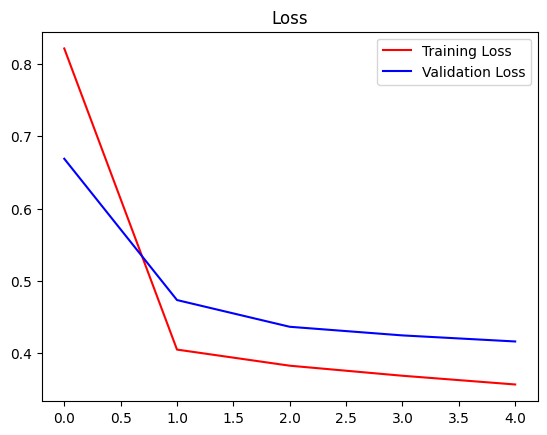

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r',label='Training Loss')
plt.plot(hist.history['val_loss'], 'b',label='Validation Loss')
plt.legend()
plt.show()

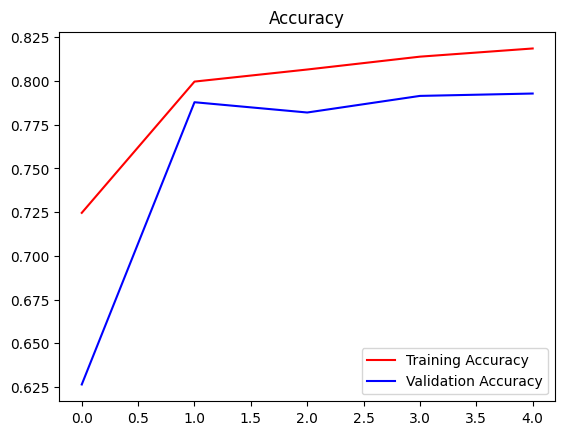

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

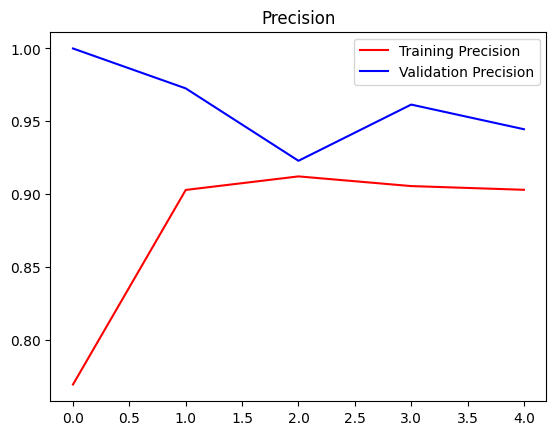

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_4'], 'r',label='Training Precision')
plt.plot(hist.history['val_precision_4'], 'b',label='Validation Precision')
plt.legend()
plt.show()

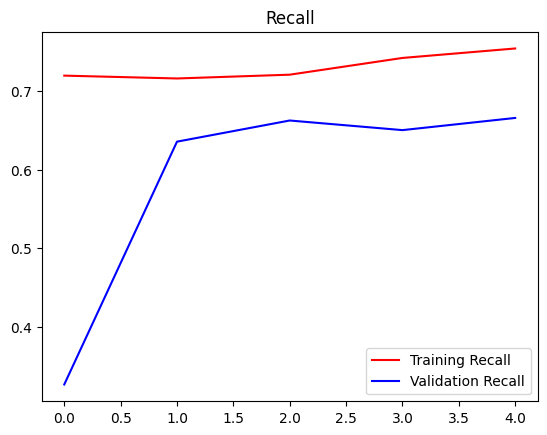

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_4'], 'r',label='Training Recall')
plt.plot(hist.history['val_recall_4'], 'b',label='Validation Recall')
plt.legend()
plt.show()

Testing the model:

In [ ]:
evaluation = model.evaluate(Xnn_test, Y_test)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Recall:", evaluation[2])
print("Test Precision:", evaluation[3])

57/57 [==============================] - 1s 24ms/step - loss: 0.6085 - accuracy: 0.7044 - recall_4: 0.0733 - precision_4: 0.4815
Test Loss: 0.6084771156311035
Test Accuracy: 0.7044199109077454
Test Recall: 0.07330827414989471
Test Precision: 0.48148149251937866


### 6.3 Deeper CNN

For the deep convolutional neural network i used a pytorch framework.

In [ ]:
#the model takes features and labels toghether in a single variable, so i will use this class for data loading
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # Get a single data sample and its corresponding label
        x = self.features[index]
        y = self.labels[index]
        return x, y

In [ ]:
Xnn_train = Xnn_train.astype(np.float32)  # Convert to float32
Ynn_train = Ynn_train.astype(np.int64)    # Convert labels to int64
train_dataset = MyDataset(Xnn_train, Ynn_train)

# Define the batch size for training
batch_size = 128

# Create the DataLoader for training
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(29, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=2)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')

num_epochs=5
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 0.64, Accuracy: 0.62
Epoch: 1, Loss: 0.47, Accuracy: 0.78
Epoch: 2, Loss: 0.45, Accuracy: 0.79
Epoch: 3, Loss: 0.42, Accuracy: 0.80
Epoch: 4, Loss: 0.42, Accuracy: 0.80
Finished Training


In [ ]:
Xnn_val = Xnn_val.astype(np.float32)
Ynn_val = Ynn_val.astype(np.int64)

val_dataset = MyDataset(Xnn_val, Ynn_val)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.79, Total items: 2211


The validation accuracy was taken into account to tune the batch size and the number of epochs.

Performance on the test set:

In [ ]:
Xnn_test = Xnn_test.astype(np.float32)
Y_test = Y_test.astype(np.int64)

test_dataset = MyDataset(Xnn_test, Y_test)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

inference(myModel, test_dl)

Accuracy: 0.42, Total items: 1810


Apparently the CNN is overfitting.
This fail in the generalization of the model is probably caused by the huge amount of augmented data in the train/validation set.

Possible improvemnts:
- Perform data augmentation only on the training data.
- Increase the dataset dimensions.
- Rely more on real data than artificial data.
- Use a less complicated architecture; indeed, the previous CNN performed way better.

# Results

## Accuracy comparison

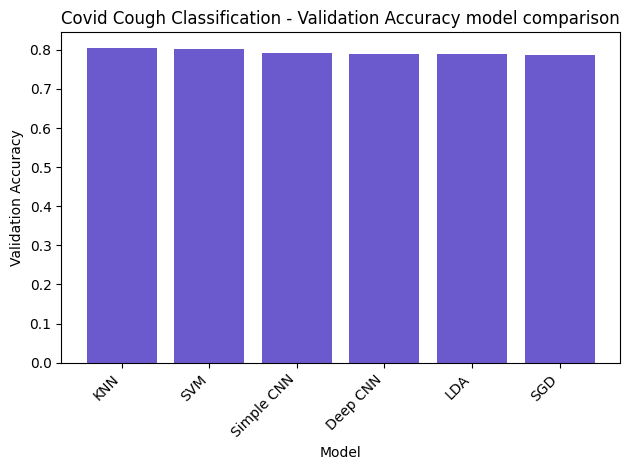

In [ ]:
val_acc = {"Deep CNN":0.79, "Simple CNN":0.7929, "SVM":0.8032, "SGD": 0.7874 , "KNN":0.8044, "LDA":0.7890 }

sorted_data = dict(sorted(val_acc.items(), key=lambda item: item[1], reverse=True))

labels = list(sorted_data.keys())
values = list(sorted_data.values())

plt.bar(labels, values, color='slateblue')

plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Covid Cough Classification - Validation Accuracy model comparison')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("Validation_accuracy_CCC.jpg")
plt.show()

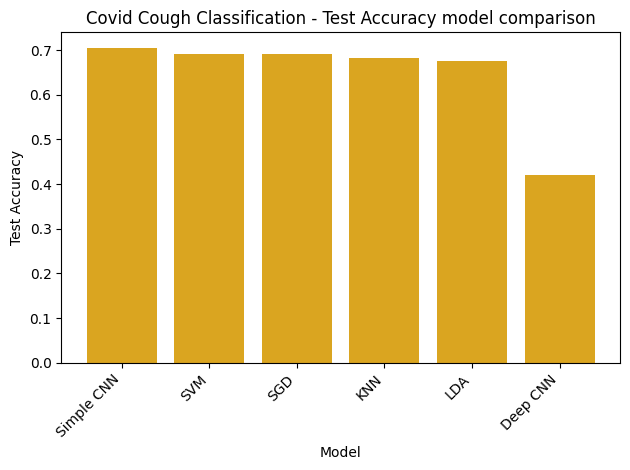

In [ ]:
test_acc = {"Deep CNN": 0.42, "Simple CNN":0.7044, "SVM":0.6911, "SGD":0.6906 , "KNN":0.6812, "LDA":0.6751 }

sorted_data = dict(sorted(test_acc.items(), key=lambda item: item[1], reverse=True))

labels = list(sorted_data.keys())
values = list(sorted_data.values())

plt.bar(labels, values, color='goldenrod')

plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Covid Cough Classification - Test Accuracy model comparison')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("Test_accuracy_CCC.jpg")
plt.show()

## Do i have Covid????

I uploaded an audio file of me coughing to apply one of the models on it.

In [76]:
! gdown 1u2LnTXmDi8-6HqGWmcxlP-x6YsIVbmWV
! gdown 14ccsrnDG5KnG7ra1MKlHaFXi8DPAAfjr

Downloading...
From: https://drive.google.com/uc?id=1u2LnTXmDi8-6HqGWmcxlP-x6YsIVbmWV
To: /content/Paolo_cough.wav
100% 282k/282k [00:00<00:00, 91.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=14ccsrnDG5KnG7ra1MKlHaFXi8DPAAfjr
To: /content/SVM_model.pkl
100% 22.6M/22.6M [00:00<00:00, 34.1MB/s]


In [75]:
ipd.Audio("Paolo_cough.wav",rate=16000)

In [72]:
def covid_tester(filename,model, sr=16000):

    #Audio segmentation
    command = f"python detect_cough.py -i {filename}"
    cough_prob = float(subprocess.check_output(command, shell=True, text=True).split(" ")[-1].strip())
    output = filename.split('.')[0]+"_processed"
    ! mkdir {output}
    if cough_prob > 0.5:
          command = f"python segment_cough.py -i {filename} -o {output}/"
          subprocess.check_output(command, shell=True, text=True)
          for file in os.listdir(output):
              file_path = os.path.join(output, file)
              audio, _ = librosa.load(file_path, sr=sr)
              padded_cough = librosa.util.fix_length(audio,size= int(0.5 * sr))
              sf.write(file_path, padded_cough, sr)

    #Feature extraction
    signal, sr = librosa.load(f"{output}/{filename.split('.')[0]}-0.wav")
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    mfccs_features = mfccs_features.flatten().reshape(1, -1)

    #Prediction
    result = model.predict(mfccs_features)

    if result[0] == 0:
        print("You don't have Covid :)")
    else:
        print("You have Covid :(")

    return

In [73]:
covid_tester("Paolo_cough.wav",joblib.load('SVM_model.pkl'))

You don't have Covid :)


Well, that's fortunate!